<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Naive Bayes with PCA for MNIST Digit Classification**
--------------------------------------------------------------

This project uses the **Naive Bayes classifier** to recognize handwritten digits from the MNIST dataset. Naive Bayes is a fast, probabilistic algorithm that applies Bayes’ Theorem and assumes features are independent. It calculates the likelihood of each digit using a Gaussian distribution and predicts the most probable class.

To handle the high dimensionality of the image data (784 features), Principal Component Analysis (PCA) is used to reduce dimensions while preserving most of the important information. This speeds up training and improves accuracy by removing noise.



Downloading...
From (original): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87
From (redirected): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87&confirm=t&uuid=97fa6318-9975-4a96-a1a1-ab3f60d9bc62
To: /content/train_dataset.csv
100%|██████████| 110M/110M [00:01<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy
To: /content/test_dataset.csv
100%|██████████| 18.3M/18.3M [00:00<00:00, 72.1MB/s]


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
Training data shape: (60000, 784)
Test data shape: (10000, 784)


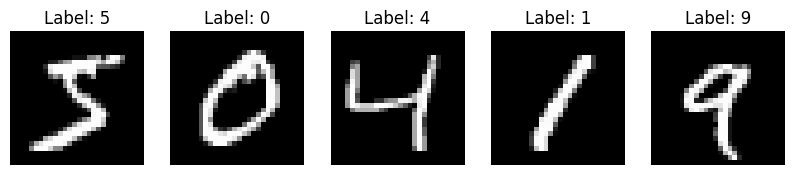

In [1]:
import numpy as np
import pandas as pd
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, precision_score,
                             recall_score, f1_score)
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

#----------------------------------------------------------------------
# file import from derive
train_file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
test_file_id = "1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy"

train_url = f"https://drive.google.com/uc?id={train_file_id}"
test_url = f"https://drive.google.com/uc?id={test_file_id}"


# downloading file
train_output = "train_dataset.csv"
test_output = "test_dataset.csv"

gdown.download(train_url, train_output, quiet=False)
gdown.download(test_url, test_output, quiet=False)


# dataframe formation
train_df = pd.read_csv(train_output, header=None)
test_df = pd.read_csv(test_output, header=None)


print(train_df.head())
#----------------------------------------------------------------------

# making y = label(1st column) and x = row (other column).

#for train dataset
y_train = train_df.iloc[:, 0].values  # Labels
X_train = train_df.iloc[:, 1:].values  # Features (pixel values)

#for test dataset
y_test = test_df.iloc[:, 0].values  # Labels
X_test = test_df.iloc[:, 1:].values  # Features (pixel values)

# shape of train and test
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

#----------------------------------------------------------------------

# displaying some images
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")

plt.show()

#Visualizing Class Distribution in Training and Testing Sets

**Brief Documentation:**
* This section visualizes the distribution of digit labels in both the training and testing datasets:

* A count plot shows how many samples belong to each digit (0–9).

* It helps to check if the dataset is balanced or if some digits appear more frequently than others.

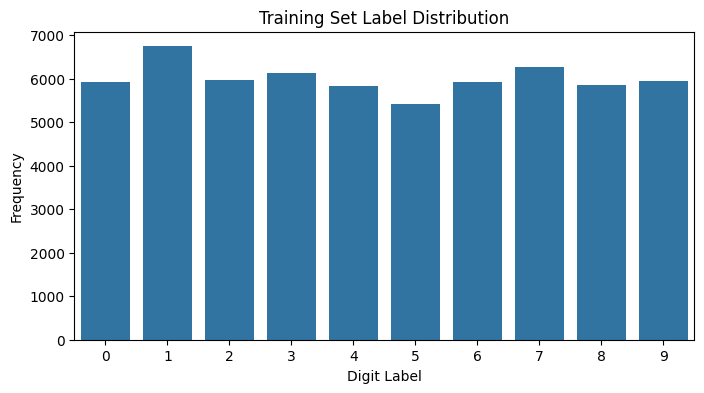

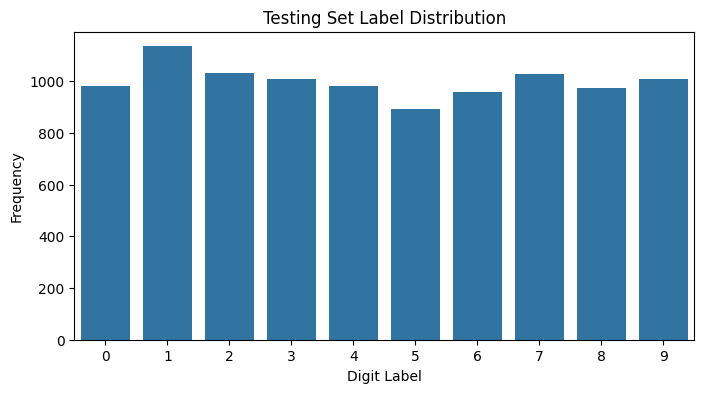

In [2]:
def plot_label_distribution(y, title="Label Distribution"):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel("Digit Label")
    plt.ylabel("Frequency")
    plt.show()

plot_label_distribution(y_train, "Training Set Label Distribution")
plot_label_distribution(y_test, "Testing Set Label Distribution")


#Define Manual PCA Implementation

**Brief Documentation:**

- **Initialization:** Sets the number of principal components (`n_components`) to retain for dimensionality reduction.

- **Fit:**  
  1. **Centering the Data:** Subtract the mean of each feature:
                            [ X_centered = X - mean(X) ]
  2. **Covariance Matrix Calculation:** Compute the covariance matrix \( C \) from the center data:

        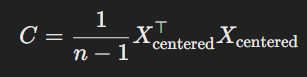

     where \( n \) is the number of samples.
  3. **Eigen Decomposition:** Find eigenvalues and eigenvectors of \( C \).
  4. **Sorting and Selecting Components:** Sort the eigenvalues and corresponding eigenvectors in descending order, then select the top `n_components`.
  5. **Explained Variance Ratio:** Calculate the variance explained by the selected components:           
                     [ explained_variance_ratio = selected eigenvalues/total variance]

- **Transform:**  
  Center new data using the previously computed mean and project it onto the principal components:

  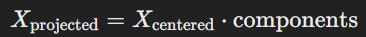

- **Fit-Transform:**  
  Performs both the fitting and transformation steps sequentially on the dataset.

In [3]:
class ManualPCA:
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        # mean of each feature and center the data
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        # covariance matrix (features as columns)
        cov_matrix = np.cov(X_centered, rowvar=False)
        # eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        # Sort eigenvalues and corresponding eigenvectors in descending order
        sorted_idx = np.argsort(eigenvalues)[::-1]
        self.explained_variance_ = eigenvalues[sorted_idx]
        eigenvectors = eigenvectors[:, sorted_idx]
        # Select first n_components eigenvectors
        self.components_ = eigenvectors[:, :self.n_components]
        # Compute explained variance ratio
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio_ = self.explained_variance_[:self.n_components] / total_variance
        return self

    def transform(self, X):
        X_centered = X - self.mean_
        return np.dot(X_centered, self.components_)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

#Define Manual Gaussian Naive Bayes Implementation

**Brief Documentation**

- **Initialization:** The constructor sets a smoothing parameter (`var_smoothing`) to avoid numerical issues when a feature's variance is zero.

- **Fit Method:**  
  Computes class-specific statistics from the training data:
  - **Class Identification:** Determines the unique classes in the target array.
  - **Mean Calculation:** For each class \( c \), compute the feature-wise mean:

      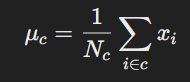

    where \( N_c \) is the number of samples in class \( c \).
  - **Variance Calculation:** For each class \( c \), compute the feature-wise variance and add smoothing:
  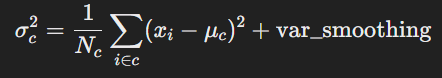
  - **Prior Calculation:** Calculate the prior probability of each class:
                     [ P(c) = N_c/N ]
    where \( N \) is the total number of samples.
  
- **Predict_Proba Method:**  
  Computes the log probabilities for each class using the Gaussian probability density function in log space:
  - **Gaussian Log-Likelihood:** For a feature \( x \) given class \( c \) with mean \(u\) and variance \(sigma^2\), the log probability is:
    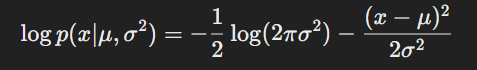

   Sum these log probabilities across all features, add the log prior
   logP(c), then convert the log probabilities to normalized probabilities using the softmax function for numerical stability.

- **Predict Method:**  
  Uses the probabilities computed by `predict_proba` to assign the class with the highest probability to each sample.

- **Parameter Methods:**  
  `get_params` and `set_params` allow integration with tools like `GridSearchCV` by exposing and updating the model parameters.

In [4]:
class ManualGaussianNB:
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.means_ = {}
        self.vars_ = {}
        self.priors_ = {}
        for cls in self.classes_:
            X_cls = X[y == cls]
            self.means_[cls] = np.mean(X_cls, axis=0)
            self.vars_[cls] = np.var(X_cls, axis=0) + self.var_smoothing
            self.priors_[cls] = X_cls.shape[0] / X.shape[0]
        return self

    def predict_proba(self, X):
        probs = []
        # For each class, compute log probability for each sample
        for cls in self.classes_:
            mean = self.means_[cls]
            var = self.vars_[cls]
            # Using Gaussian probability density function in log space
            log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * var))
            log_likelihood += -0.5 * np.sum(((X - mean) ** 2) / var, axis=1)
            log_prior = np.log(self.priors_[cls])
            probs.append(log_likelihood + log_prior)
        probs = np.vstack(probs).T  # (n_samples, n_classes)
        # Convert log probabilities to probabilities using softmax for numerical stability
        max_log = np.max(probs, axis=1, keepdims=True)
        probs_exp = np.exp(probs - max_log)
        proba = probs_exp / np.sum(probs_exp, axis=1, keepdims=True)
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

    # For compatibility with GridSearchCV
    def get_params(self, deep=True):
        return {"var_smoothing": self.var_smoothing}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

#Data Loading and Preprocessing

**Brief Documentation:**

- **Loading:** Reads CSV files into DataFrames; raises an error if files are missing.
- **Imputation:** Fills missing values with the column mean:
                      [ x_imputed = mean(column) ]
- **Splitting:** Separates the first column as labels and the rest as features.
- **Normalization:** Scales pixel values from 0–255 to 0–1:
                  [ normalized_value = pixel_value/255.0 ]

In [5]:
def load_data(train_path, test_path):
    try:
        train_data = pd.read_csv(train_path, header=None)
        test_data = pd.read_csv(test_path, header=None)
        print("Datasets loaded successfully.")
        return train_data, test_data
    except FileNotFoundError as e:
        print(f"Error: CSV files not found. Ensure '{train_path}' and '{test_path}' exist in your working directory.")
        raise e

def check_and_impute(data, name="Data"):
    print(f"\nChecking for missing values in {name}:")
    missing_counts = data.isnull().sum()
    print(missing_counts)
    if data.isnull().values.any():
        data.fillna(data.mean(), inplace=True)
        print(f"Missing values in {name} filled with column means.")
    else:
        print(f"No missing values found in {name}.")
    return data

# Load and Preprocess the Data
train_data, test_data = load_data("train_dataset.csv", "test_dataset.csv")
train_data = check_and_impute(train_data, "training data")
test_data = check_and_impute(test_data, "testing data")

# The first column is assumed to be the label
label_column = train_data.columns[0]
X_train = train_data.drop(label_column, axis=1)
y_train = train_data[label_column]
X_test = test_data.drop(label_column, axis=1)
y_test = test_data[label_column]

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

# Normalize pixel values (from 0-255 to 0-1)
scaling_factor = 255.0
X_train_norm = X_train / scaling_factor
X_test_norm = X_test / scaling_factor

Datasets loaded successfully.

Checking for missing values in training data:
0      0
1      0
2      0
3      0
4      0
      ..
780    0
781    0
782    0
783    0
784    0
Length: 785, dtype: int64
No missing values found in training data.

Checking for missing values in testing data:
0      0
1      0
2      0
3      0
4      0
      ..
780    0
781    0
782    0
783    0
784    0
Length: 785, dtype: int64
No missing values found in testing data.

Training data shape: (60000, 784)
Testing data shape: (10000, 784)


#Apply Manual PCA and Hyperparameter Tuning

**Brief Documentation:**

The dataset is transformed using the top 60 principal components, retaining most of its variance.

* **Explained Variance:** It measures how much information is retained after PCA transformation.
  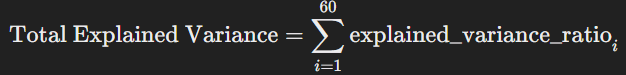

* **Hyperparameter Tuning with GridSearchCV:** GridSearchCV is used to tune the `var_smoothing` parameter of Gaussian Naïve Bayes over 100 values for better accuracy.

* **Cross-Validation:** A 5-fold cross-validation (CV) is performed to evaluate the model’s accuracy.
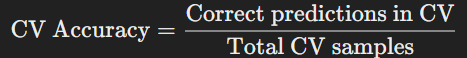

* **Accuracy:** is computed by comparing predicted and actual labels from the test set.
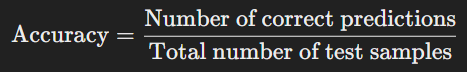


In [6]:
# --- Apply Manual PCA to reduce dimensionality ---
pca_components = 60
pca = ManualPCA(n_components=pca_components)
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

print("\nPCA transformed training data shape:", X_train_pca.shape)
print("PCA transformed testing data shape:", X_test_pca.shape)
explained_variance = np.sum(pca.explained_variance_ratio_)
print("Total explained variance by {} components: {:.2f}%".format(pca_components, explained_variance * 100))

# Hyperparameter Tuning with GridSearchCV for ManualGaussianNB
param_grid = {"var_smoothing": np.logspace(-10, -1, 100)}
grid_search = GridSearchCV(estimator=ManualGaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)
print("\nBest hyperparameters:", grid_search.best_params_)
print("Best cross-validation Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# Use best estimator from grid search for further predictions
best_gnb = grid_search.best_estimator_

# Evaluate Tuned Model on the Test Set
y_pred = best_gnb.predict(X_test_pca)

# Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy with tuned ManualGaussianNB: {:.2f}%".format(accuracy * 100))


PCA transformed training data shape: (60000, 60)
PCA transformed testing data shape: (10000, 60)
Total explained variance by 60 components: 85.26%

Best hyperparameters: {'var_smoothing': np.float64(0.012328467394420685)}
Best cross-validation Accuracy: 87.19%

Test Accuracy with tuned ManualGaussianNB: 88.15%


#Confusion Matrix and Classification Report

**Brief Documentation:**
* **Confusion Matrix:** A table that shows the number of correct and incorrect predictions made by the model, organized by actual and predicted labels. It helps identify which digits are being misclassified.

* **Classification Report:** Provides detailed metrics like precision, recall, and F1-score for each class (digit).

          Precision = TP/(TP+FP)
          [Correctly predicted / Total predicted as that class]

          Recall = TP/(TP+FN)
          [Correctly predicted / Total actual in that class]

          F1-score = Harmonic mean of precision and recall


Confusion Matrix:
[[ 925    0    8    5    0   28    9    4    1    0]
 [   0 1077   16    5    0   10    6    2   18    1]
 [  18    2  871   27   17    9    9   20   52    7]
 [   6    2   21  879    3   36    4   17   29   13]
 [   1    6   14    1  854    8   11    3    5   79]
 [   8    2    4   56   11  759   10   12   25    5]
 [   7    2   10    2   12   38  885    0    1    1]
 [   2   28   31    2   22    8    0  876   13   46]
 [   9    5   15   35   11   39    5   10  832   13]
 [  10    5   21    9   51   20    1   23   12  857]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       980
           1       0.95      0.95      0.95      1135
           2       0.86      0.84      0.85      1032
           3       0.86      0.87      0.87      1010
           4       0.87      0.87      0.87       982
           5       0.79      0.85      0.82       892
           6       0.94      0.92      0.93    

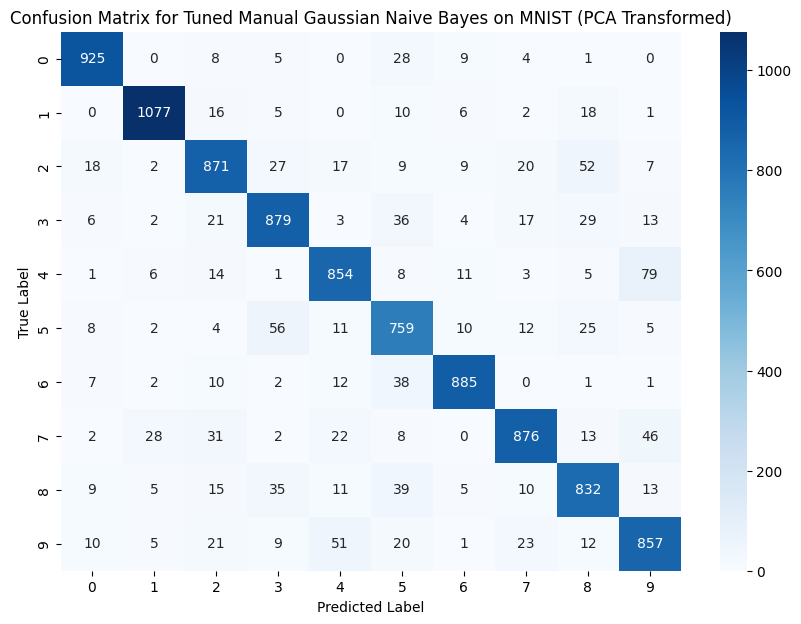

In [7]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

# Additional evaluation metrics (macro-averaged)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Macro-Average Precision: {:.4f}".format(precision_macro))
print("Macro-Average Recall: {:.4f}".format(recall_macro))
print("Macro-Average F1 Score: {:.4f}".format(f1_macro))

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix for Tuned Manual Gaussian Naive Bayes on MNIST (PCA Transformed)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#ROC and Precision-Recall Curve

**Brief Documentation:**

* **ROC Curve** (Receiver Operating Characteristic)**:**

    * ROC curve plots **TPR vs. FPR** for different thresholds.

            TPR (True Positive Rate / Recall) = TP/(TP+FN)

            FPR (False Positive Rate) = FP/(FP+TN)

    * AUC (Area Under Curve) measures how well the classifier separates class i from the rest — the higher, the better (max = 1.0).


 * **Precision-Recall (PR) Curve:**

     * PR curve shows the tradeoff between precision and recall for each class.

     * Average Precision (AP) measures area under the Precision-Recall curve; higher AP means better performance

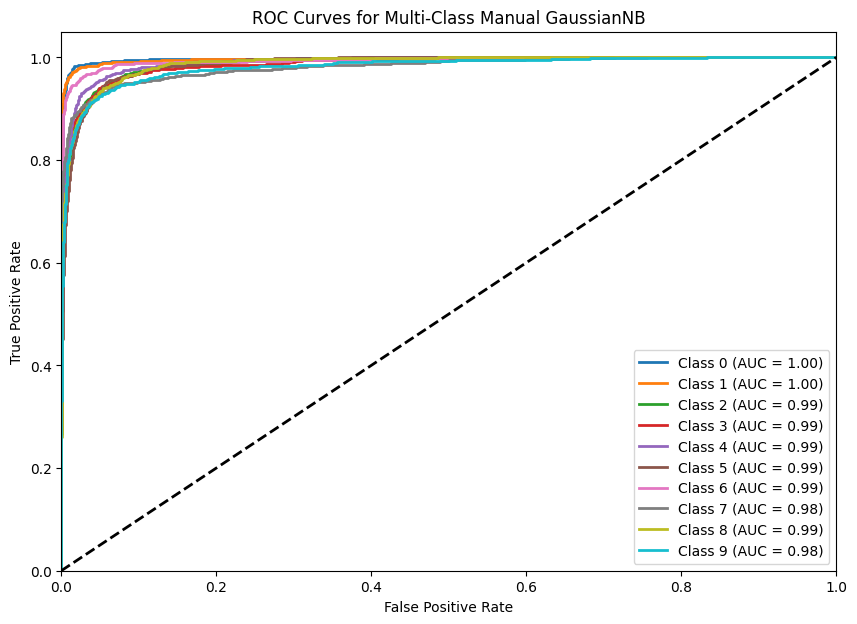

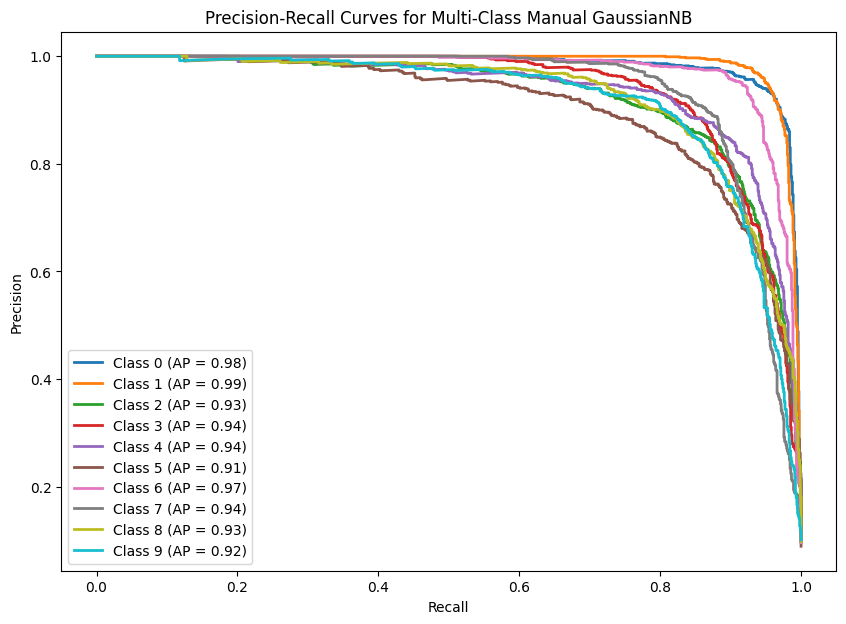

In [8]:
# Compute predicted probabilities for each class using the tuned model
y_prob = best_gnb.predict_proba(X_test_pca)
n_classes = 10

# Binarize the true labels for multi-class evaluation (one-hot encoding)
y_test_bin = np.eye(n_classes)[y_test]

# Initialize dictionaries to store metrics for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision_dict = dict()
recall_dict = dict()
average_precision = dict()

# Compute ROC curve and Precision-Recall curve for each class
for i in range(n_classes):
    # ROC curve and ROC AUC
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Precision-Recall curve and Average Precision
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_prob[:, i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Manual GaussianNB')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curves for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(recall_dict[i], precision_dict[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multi-Class Manual GaussianNB')
plt.legend(loc="lower left")
plt.show()

#Accuracy per Class Bar Chart

**Brief Documentation:**

* The per-class accuracy score (between 0 and 1) is showing how well the model predicts each digit individually.

             Class Accuracy = Correct Predictions(TP)/Total samples of class

* A bar plot is used to visualize class-wise performance, helping identify digits that are harder to classify.

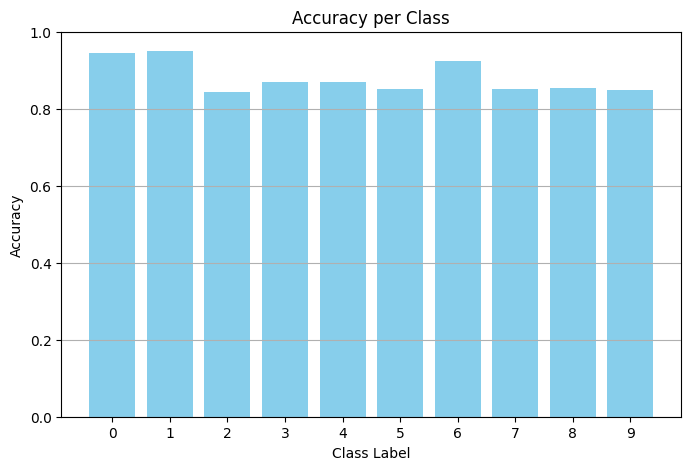

In [9]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8, 5))
plt.bar(range(10), class_accuracy, color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Accuracy per Class")
plt.xticks(range(10))
plt.grid(axis="y")
plt.show()

#Explained Variance vs. Number of PCA Components

**Brief Documentation:**
* This section evaluates how much total variance in the data is captured by varying the number of PCA components.

* For each component count from 50 to 100, PCA is applied and the explained variance ratio is recorded.

* The total explained variance increases as more components are added.

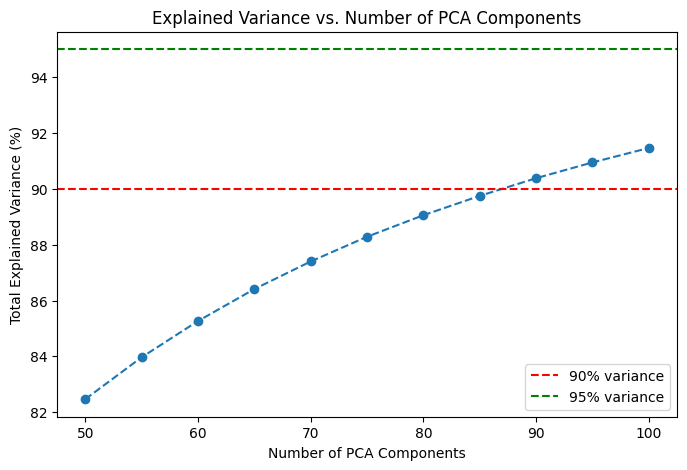

In [10]:
explained_variance_ratios = []
num_components_list = list(range(50, 101, 5))  # Check from 50 to 100 components in steps of 5

for n in num_components_list:
    pca = ManualPCA(n_components=n)
    pca.fit(X_train_norm)
    explained_variance_ratios.append(np.sum(pca.explained_variance_ratio_))

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(num_components_list, np.array(explained_variance_ratios) * 100, marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Total Explained Variance (%)')
plt.title('Explained Variance vs. Number of PCA Components')
plt.axhline(y=90, color='r', linestyle='--', label="90% variance")
plt.axhline(y=95, color='g', linestyle='--', label="95% variance")
plt.legend()
plt.show()


#Cross-Validation to Find Best PCA Components

**Brief Documentation:**
* This section aims to determine the most effective number of PCA components for classifying handwritten digits.

* Cross-validated accuracy is calculated for each setting, ensuring that the evaluation is robust and generalizes well to unseen data and The number of components yielding the highest mean accuracy is selected

In [11]:
best_accuracy = 0
best_n_components = None

for n in num_components_list:
    pca = ManualPCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_norm)

    # Apply Naive Bayes and check accuracy
    gnb = ManualGaussianNB()
    scores = cross_val_score(gnb, X_train_pca, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()

    print(f"PCA Components: {n}, CV Accuracy: {mean_accuracy:.4f}")

    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_n_components = n

print(f"\nBest PCA Components: {best_n_components}, Best Accuracy: {best_accuracy:.4f}")


PCA Components: 50, CV Accuracy: 0.8688
PCA Components: 55, CV Accuracy: 0.8698
PCA Components: 60, CV Accuracy: 0.8708
PCA Components: 65, CV Accuracy: 0.8720
PCA Components: 70, CV Accuracy: 0.8716
PCA Components: 75, CV Accuracy: 0.8717
PCA Components: 80, CV Accuracy: 0.8697
PCA Components: 85, CV Accuracy: 0.8694
PCA Components: 90, CV Accuracy: 0.8689
PCA Components: 95, CV Accuracy: 0.8685
PCA Components: 100, CV Accuracy: 0.8663

Best PCA Components: 65, Best Accuracy: 0.8720


#Cost Function Graph

**Brief Documentation:**

* **Cost Function** computes the Negative Log-Likelihood (NLL) cost for each test sample, which measures how confident the model is in predicting the correct class.
              Cost = −log(Probability of True Class)

* A lower cost indicates the model was confident and correct; a higher cost means low confidence in the correct class (or incorrect prediction).

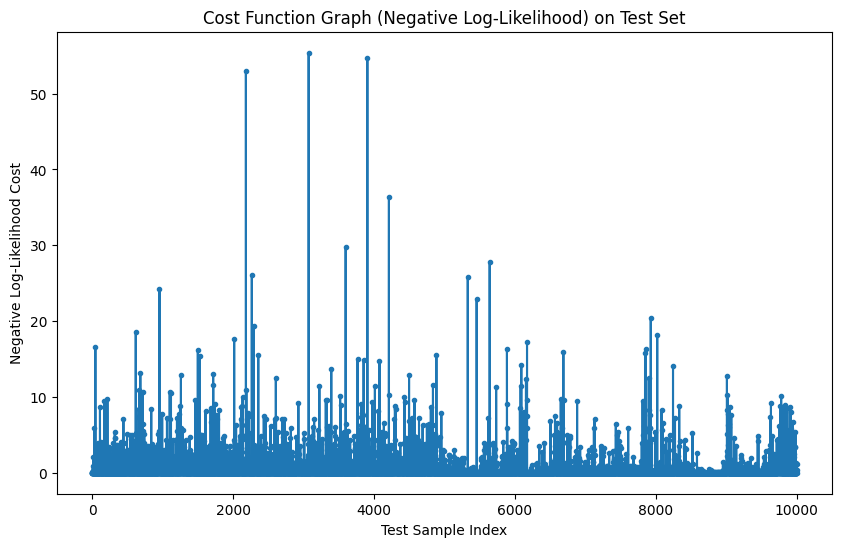

In [12]:
# For each test sample, the cost is -log(probability of the true class).
cost_values = []
for i in range(len(y_test)):
    true_class = y_test.iloc[i]
    prob_true = y_prob[i, true_class]
    cost = -np.log(prob_true)
    cost_values.append(cost)

plt.figure(figsize=(10, 6))
plt.plot(cost_values, marker='o', linestyle='-', markersize=3)
plt.xlabel("Test Sample Index")
plt.ylabel("Negative Log-Likelihood Cost")
plt.title("Cost Function Graph (Negative Log-Likelihood) on Test Set")
plt.show()

#Sample Predictions Display

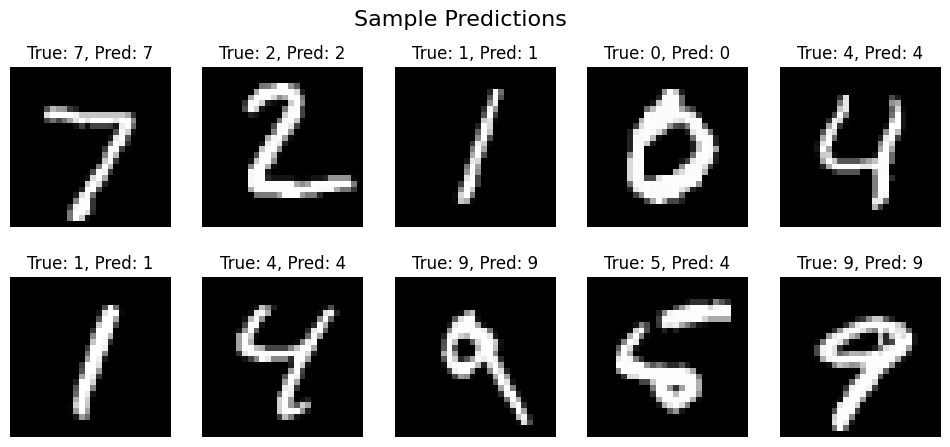

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Sample Predictions", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test.iloc[i].values.reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test.iloc[i]}, Pred: {y_pred[i]}")
    ax.axis("off")

plt.show()